In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection


import os
import xmltodict
import numpy as np
from tqdm import tqdm
from PIL import Image

In [66]:
class YOLO_PASCAL_VOC(VOCDetection):
    def __getitem__(self, index):
        """
        전처리
        결과 : X(image), y(label)
        """
        img = Image.open(self.images[index]).convert('RGB')
        
        img = img.resize((224,224))
        img_transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Resize((224,224))
        ])
        img = torch.divide(img_transform(img), 255)
        
        target = xmltodict.parse(open(self.annotations[index], mode='rb'))
        
        classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                   "bus", "car", "cat", "chair", "cow", "diningtable",
                   "dog", "horse", "motorbike", "person", "pottedplant",
                   "sheep", "sofa", "train", "tvmonitor"]
        
        label = np.zeros((7, 7, 25), dtype = float)
        # 격자 구조
        
        Image_Height = float(target['annotation']['size']['height'])
        Image_Width = float(target['annotation']['size']['width'])
        
#         plt.imshow(img.transpose(0, 1).transpose(1, 2))
#         ax = plt.gca()
        try:
            for i, obj in enumerate(target['annotation']['object']):
                class_index = classes.index(obj['name'].lower())
                
                x_min = float(obj['bndbox']['xmin']) 
                y_min = float(obj['bndbox']['ymin'])
                x_max = float(obj['bndbox']['xmax']) 
                y_max = float(obj['bndbox']['ymax'])
                
                
                
                x_min = float((224.0/Image_Width)*x_min)
                y_min = float((224.0/Image_Height)*y_min)
                x_max = float((224.0/Image_Width)*x_max)
                y_max = float((224.0/Image_Height)*y_max)
                
#                 rect = patches.Rectangle((x_min, y_min),
#                                         (x_max - x_min + 1),
#                                         (y_max - y_min + 1),
#                                         linewidth=2,
#                                         edgecolor='red',
#                                         fill=False,)
#                 ax.add_patch(rect)
                
                x = (x_min + x_max) / 2.0
                y = (y_min + y_max) / 2.0
                w = x_max - x_min + 1
                h = y_max - y_min + 1
                
                x_cell = int(x/32)
                y_cell = int(y/32)
                
                x_val_inCell = float((x - x_cell * 32.0)/32.0)
                y_val_inCell = float((y - y_cell * 32.0)/32.0)
                
                w = w / 224.0
                h = h / 224.0
                
                
                class_index_inCell = class_index + 5
                
                label[y_cell][x_cell][0] = x_val_inCell
                label[y_cell][x_cell][1] = y_val_inCell
                label[y_cell][x_cell][2] = w
                label[y_cell][x_cell][3] = h
                label[y_cell][x_cell][4] = 1.0
                label[y_cell][x_cell][class_index_inCell] = 1.0
                
    
        # Single-Object in Image
        except TypeError:
            obj = target['annotation']['object']
            class_index = classes.index(obj['name'].lower())
                
            x_min = float(obj['bndbox']['xmin']) 
            y_min = float(obj['bndbox']['ymin'])
            x_max = float(obj['bndbox']['xmax']) 
            y_max = float(obj['bndbox']['ymax'])
            
            

            x_min = float((224.0/Image_Width)*x_min)
            y_min = float((224.0/Image_Height)*y_min)
            x_max = float((224.0/Image_Width)*x_max)
            y_max = float((224.0/Image_Height)*y_max)
            
#             rect = patches.Rectangle((x_min, y_min),
#                         (x_max - x_min + 1),
#                         (y_max - y_min + 1),
#                         linewidth=2,
#                         edgecolor='red',
#                         fill=False,)
#             ax.add_patch(rect)

            x = (x_min + x_max)/2.0
            y = (y_min + y_max)/2.0
            w = x_max - x_min + 1
            h = y_max - y_min + 1

            x_cell = int(x/32) 
            y_cell = int(y/32) 
            x_val_inCell = float((x - x_cell * 32.0)/32.0) 
            y_val_inCell = float((y - y_cell * 32.0)/32.0)

            w = w / 224.0
            h = h / 224.0

            class_index_inCell = class_index + 5

            label[y_cell][x_cell][0] = x_val_inCell
            label[y_cell][x_cell][1] = y_val_inCell
            label[y_cell][x_cell][2] = w
            label[y_cell][x_cell][3] = h
            label[y_cell][x_cell][4] = 1.0
            label[y_cell][x_cell][class_index_inCell] = 1.0
        finally:
            plt.show()

        return img, torch.tensor(label)
            

In [ ]:
current_path = os.getcwd()
path2data = current_path + '/voc'
if not os.path.exists(path2data): 
    os.mkdir(path2data)
    
BATCH_SIZE = 64
EPOCH = 135

Train_Dataset = YOLO_PASCAL_VOC(path2data, year='2007', image_set='train', download=True)
Test_Dataset = YOLO_PASCAL_VOC(path2data, year='2007', image_set='test', download=True)

data_loader = torch.utils.data.DataLoader(dataset=Train_Dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

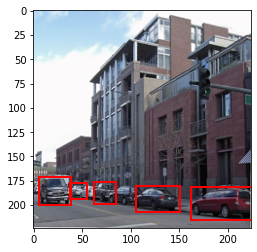

In [85]:
X, label = Test_Dataset[3]

img = X.transpose(0, 1).transpose(1, 2)
plt.imshow(img)
ax = plt.gca()

S, S, _ = label.shape
for y_cell in range(S):
    for x_cell in range(S):
        x = label[y_cell, x_cell, 0]
        y = label[y_cell, x_cell, 1]
        w = label[y_cell, x_cell, 2]
        h = label[y_cell, x_cell, 3]
        
        x = (x + x_cell) * 32
        y = (y + y_cell) * 32
        w = w * 224.0
        h = h * 224.0

        x_min = x - w * 0.5
        x_max = x + w * 0.5
        y_min = y - h * 0.5
        y_max = y + h * 0.5
        if w > 0 and h > 0:
            rect = patches.Rectangle((x_min, y_min),
                         w,
                         h,
                        linewidth=2,
                        edgecolor='red',
                        fill=False,)
            ax.add_patch(rect)

In [3]:
class YOLO(nn.Module):
    def __init__(self, VGG16):
        super().__init__()
        
        self.backbone = VGG16
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(512), # in_channels
            nn.Conv2d(in_channels = 512,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.BatchNorm1d(7*7*1024),
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 1470)
        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.conv(out)
        out = self.linear(out)
        out = torch.reshape(out, (-1 ,7, 7, 30))
        return out

In [4]:
def yolo_multitask_loss(y_pred, y_true):
    """
    y_pred : [bounding_box_pred1, bounding_box_pred2, ...]
    y_true : [bounding_box, ...]
    """
    batch_loss = 0
    
    count = len(y_true)
    for i in range(count):
        """
        batch loop
        """
        y_true_unit = y_true[i].clone().detach().requires_grad_(True)
        y_pred_unit = y_pred[i].clone().detach().requires_grad_(True)
        y_true_unit = torch.reshape(y_true_unit, [49, 25])
        y_pred_unit = torch.reshape(y_pred_unit, [49, 30])

        loss = 0.0
        for j in range(0, len(y_true_unit)):
            """
            49: 격자 수
            """
            bbox1_pred = y_pred_unit[j, 0:4].clone().detach().requires_grad_(True)
            bbox1_pred_confidence = y_pred_unit[j, 4].clone().detach().requires_grad_(True)
            bbox2_pred = y_pred_unit[j, 5:9].clone().detach().requires_grad_(True)
            bbox2_pred_confidence = y_pred_unit[j, 9].clone().detach().requires_grad_(True)
            
            class_pred = y_pred_unit[j, 10:].clone().detach().requires_grad_(True)
            
            bbox_true = y_true_unit[j, :4].clone().detach().requires_grad_(True)
            bbox_true_confidence = y_true_unit[j, 4].clone().detach().requires_grad_(True)
            class_true = y_true_unit[j, 5:].clone().detach().requires_grad_(True)

            # IoU
            box_pred_1_np = bbox1_pred.detach().numpy()
            box_pred_2_np = bbox2_pred.detach().numpy()
            box_true_np = bbox_true.detach().numpy()

            bbox_true = y_true_unit[j, :4].clone().detach().requires_grad_(True)
            bbox_true_confidence = y_true_unit[j, 4].clone().detach().requires_grad_(True)
            class_true = y_true_unit[j, 5:].clone().detach().requires_grad_(True)

            # 바운딩 박스 좌표에서 [min_x, min_y, max_x, max_y]
            box_pred_1_minmax = np.asarray([box_pred_1_np[0] - 0.5*box_pred_1_np[2], box_pred_1_np[1] - 0.5*box_pred_1_np[3], box_pred_1_np[0] + 0.5*box_pred_1_np[2], box_pred_1_np[1] + 0.5*box_pred_1_np[3]])
            box_pred_2_minmax = np.asarray([box_pred_2_np[0] - 0.5*box_pred_2_np[2], box_pred_2_np[1] - 0.5*box_pred_2_np[3], box_pred_2_np[0] + 0.5*box_pred_2_np[2], box_pred_2_np[1] + 0.5*box_pred_2_np[3]])
            box_true_minmax   = np.asarray([box_true_np[0] - 0.5*box_true_np[2], box_true_np[1] - 0.5*box_true_np[3], box_true_np[0] + 0.5*box_true_np[2], box_true_np[1] + 0.5*box_true_np[3]])

            # [max(pred_x_min, true_x_min), max(pred_y_min, true_y_min), min(pred_x_max, true_x_max), min(pred_y_max, true_y_max)]
            InterSection_pred_1_with_true = [max(box_pred_1_minmax[0], box_true_minmax[0]), max(box_pred_1_minmax[1], box_true_minmax[1]), min(box_pred_1_minmax[2], box_true_minmax[2]), min(box_pred_1_minmax[3], box_true_minmax[3])]
            InterSection_pred_2_with_true = [max(box_pred_2_minmax[0], box_true_minmax[0]), max(box_pred_2_minmax[1], box_true_minmax[1]), min(box_pred_2_minmax[2], box_true_minmax[2]), min(box_pred_2_minmax[3], box_true_minmax[3])]


            IntersectionArea_pred_1_true = 0
            if (InterSection_pred_1_with_true[2] - InterSection_pred_1_with_true[0] + 1) >= 0 and (InterSection_pred_1_with_true[3] - InterSection_pred_1_with_true[1] + 1) >= 0 :
                width = InterSection_pred_1_with_true[2] - InterSection_pred_1_with_true[0] + 1
                height = InterSection_pred_1_with_true[3] - InterSection_pred_1_with_true[1] + 1
                IntersectionArea_pred_1_true = width * height
            else:
                IntersectionArea_pred_1_true = 0.0
            
            IntersectionArea_pred_2_true = 0.0
            if (InterSection_pred_2_with_true[2] - InterSection_pred_2_with_true[0] + 1) >= 0 and (InterSection_pred_2_with_true[3] - InterSection_pred_2_with_true[1] + 1) >= 0 :
                IntersectionArea_pred_2_true = (InterSection_pred_2_with_true[2] - InterSection_pred_2_with_true[0] + 1) * (InterSection_pred_2_with_true[3] - InterSection_pred_2_with_true[1] + 1)
            else:
                IntersectionArea_pred_2_true = 0.0
            
            box_pred_1_area = (box_pred_1_minmax[2] - box_pred_1_minmax[0] + 1) * (box_pred_1_minmax[3] - box_pred_1_minmax[1] + 1)
            box_pred_2_area = (box_pred_2_minmax[2] - box_pred_2_minmax[0] + 1) * (box_pred_2_minmax[3] - box_pred_2_minmax[1] + 1)
            box_true_area = (box_true_minmax[2] - box_true_minmax[0] + 1) * (box_true_minmax[3] - box_true_minmax[1] + 1)
            
            Union_pred_1_true = box_pred_1_area + box_true_area - IntersectionArea_pred_1_true
            Union_pred_2_true = box_pred_2_area + box_true_area - IntersectionArea_pred_2_true

            IoU_box_1 = IntersectionArea_pred_1_true/Union_pred_1_true
            IoU_box_2 = IntersectionArea_pred_2_true/Union_pred_2_true

            responsible_box = torch.zeros(4)
            responsible_bbox_confidence = 0
            non_responsible_bbox_confidence = 0

            if IoU_box_1 >= IoU_box_2 :
                responsible_box = bbox1_pred.clone().detach().requires_grad_(True)
                responsible_bbox_confidence = bbox1_pred_confidence.clone().detach().requires_grad_(True)
                non_responsible_bbox_confidence = bbox2_pred_confidence.clone().detach().requires_grad_(True)
                                
            else :
                responsible_box = bbox2_pred.clone().detach().requires_grad_(True)
                responsible_bbox_confidence = bbox2_pred_confidence.clone().detach().requires_grad_(True)
                non_responsible_bbox_confidence = bbox1_pred_confidence.clone().detach().requires_grad_(True)
            
            obj_exist = torch.ones_like(bbox_true_confidence)
            if box_true_np[0] == 0.0 and box_true_np[1] == 0.0 and box_true_np[2] == 0.0 and box_true_np[3] == 0.0 : 
                obj_exist = torch.zeros_like(bbox_true_confidence) 

            localization_err_x = torch.pow( torch.subtract(bbox_true[0], responsible_box[0]), 2) 
            localization_err_y = torch.pow( torch.subtract(bbox_true[1], responsible_box[1]), 2) 

            localization_err_w = torch.pow( torch.subtract(torch.sqrt(bbox_true[2]), torch.sqrt(responsible_box[2])), 2) 
            localization_err_h = torch.pow( torch.subtract(torch.sqrt(bbox_true[3]), torch.sqrt(responsible_box[3])), 2) 

            if torch.isnan(localization_err_w).detach().numpy() == True :
                localization_err_w = torch.zeros_like(localization_err_w)
            
            if torch.isnan(localization_err_h).detach().numpy() == True :
                localization_err_h = torch.zeros_like(localization_err_h)
            
            localization_err_1 = torch.add(localization_err_x, localization_err_y)
            localization_err_2 = torch.add(localization_err_w, localization_err_h)
            localization_err = torch.add(localization_err_1, localization_err_2)
            
            weighted_localization_err = torch.multiply(localization_err, 5.0)    
            weighted_localization_err = torch.multiply(weighted_localization_err, obj_exist)

            class_confidence_score_obj = torch.pow(torch.subtract(responsible_bbox_confidence, bbox_true_confidence), 2)
            class_confidence_score_obj = torch.mul(class_confidence_score_obj, obj_exist)
            
            class_confidence_score_noobj = torch.pow(torch.subtract(non_responsible_bbox_confidence, torch.zeros_like(bbox_true_confidence)), 2)
            class_confidence_score_noobj = torch.multiply(class_confidence_score_noobj, 0.5)
            class_confidence_score_noobj = torch.mul(class_confidence_score_noobj, torch.subtract(torch.ones_like(obj_exist), obj_exist))

            class_confidence_score = torch.add(class_confidence_score_obj,  class_confidence_score_noobj) 


            classification_err = torch.pow(torch.subtract(class_true, class_pred), 2.0)
            classification_err = torch.sum(classification_err)
            classification_err = torch.multiply(classification_err, obj_exist)

            loss_OneCell_1 = torch.add(weighted_localization_err, class_confidence_score)
            
            loss_OneCell = torch.add(loss_OneCell_1, classification_err)

            if loss == 0 :
                loss = loss_OneCell.clone().detach().requires_grad_(True)
            else :
                loss = torch.add(loss, loss_OneCell)
        


        if batch_loss == 0:
            batch_loss = loss.clone().detach().requires_grad_(True)
            batch_loss = torch.divide(batch_loss, count) # 평균 오차 구하기
        else:
            batch_loss = torch.add(batch_loss, torch.divide(loss, count))
    
    return batch_loss

In [5]:
def train_YOLO(YOLO_model, criterion, optimizer, scheduler, epochs, data_loader, device) :
    YOLO_model.train() # Train mode 진입!
    
    pbar = tqdm(range(epochs), desc="training", mininterval=0.01)
    
    best_loss = float('inf')
    for epoch in pbar:
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
             
            outputs = YOLO_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()

            # 배치로 학습시킬 때마다 loss 보여주기
            pbar_str = "training, [loss = %.4f]" % loss.item()
            pbar.set_description(pbar_str)
            
            # Save best model
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(YOLO_model.state_dict(), "./yolov1.pt")
        # lr decay
        scheduler.step()
    
    # Return best model
    YOLO_model.load_state_dict(torch.load("./yolov1.pt"))
    return model

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Using downloaded and verified file: /Users/teddy/BearTeam/edu/model/voc/VOCtrainval_06-Nov-2007.tar
Extracting /Users/teddy/BearTeam/edu/model/voc/VOCtrainval_06-Nov-2007.tar to /Users/teddy/BearTeam/edu/model/voc
Using downloaded and verified file: /Users/teddy/BearTeam/edu/model/voc/VOCtest_06-Nov-2007.tar
Extracting /Users/teddy/BearTeam/edu/model/voc/VOCtest_06-Nov-2007.tar to /Users/teddy/BearTeam/edu/model/voc


In [7]:
VGGNet = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)


for i in range(len(VGGNet.features[:-1])) :
    if type(VGGNet.features[i]) == type(nn.Conv2d(64,64,3)) :
        VGGNet.features[i].weight.requires_grad = False
        VGGNet.features[i].bias.requires_grad = False
        VGGNet.features[i].padding = 1

backbone = VGGNet.features[:-1]
YOLO_model =  YOLO(backbone).to(device) # Create YOLO model
optimizer = torch.optim.SGD(YOLO_model.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)


if os.path.exists('./yolov1.pt'):
    YOLO_model.load_state_dict(torch.load("./yolov1.pt"))

YOLO_model = train_YOLO(YOLO_model, yolo_multitask_loss, optimizer, scheduler, EPOCH, data_loader, device)

Using cache found in /Users/teddy/.cache/torch/hub/pytorch_vision_v0.10.0
training, [loss = 23.3988]:  48%|████▎    | 65/135 [7:01:51<7:34:18, 389.40s/it]


KeyboardInterrupt: 

In [138]:
# https://wolfy.tistory.com/259
from operator import itemgetter, attrgetter

def getIOU(box1, box2):
    """
    box : [x, y, w, h]
    """
    x, y, w, h = box1
    box1_x_min = x - 0.5 * w
    box1_x_max = x + 0.5 * w
    box1_y_min = y - 0.5 * h
    box1_y_max = y + 0.5 * h
    
    x, y, w, h = box2
    box2_x_min = x - 0.5 * w
    box2_x_max = x + 0.5 * w
    box2_y_min = y - 0.5 * h
    box2_y_max = y + 0.5 * h
    
    iou_x_min = max(box1_x_min, box2_x_min)
    iou_x_max = min(box1_x_max, box2_x_max)
    iou_y_min = max(box1_y_min, box2_y_min)
    iou_y_max = min(box1_y_max, box2_y_max)
    
    iou_w = iou_x_max - iou_x_min + 1
    iou_h = iou_y_max - iou_y_min + 1
    
    # 겹치는지 판단하기
    if iou_w > 0 and iou_h > 0:
        return iou_w * iou_h
    else:
        return 0.0 # 겹치지 않으면, 0!

def applyNonMaximumSupression(boxes, labels, confidences, class_scores):
    """
    boxes: [tensor([x, y, w, h]), ...]
    labels: [tensor([class]), ...]
    confidences: [tensor([conf]), ...]
    class_scores: [tensor([score]), ...]
    
    Algo:
        1. confidence_threshold 이하의 box 제거
        2. confidence 순서로 정렬(높은 것부터!)
        3. 가장 높은 confidence를 가진 box와 IOU가 threshold보다 큰 box 제거!
        4. 2 - 3 을 반복(더 이상 제거되는 박스가 없을 때까지)
    """
    confidence_threshold = 0.1
    iou_threshold = 0.5
    
    data = list(zip(boxes, labels, confidences, class_scores))

    data = list(filter(lambda datum: datum[2] > confidence_threshold, data))
    data = sorted(data, key=itemgetter(2), reverse = True)
    result = []
    while len(data) > 0:
        highest = data[0]
        result.append(highest)
        data = list(filter(lambda datum: getIOU(highest[0], datum[0]) > iou_threshold, data[1:]))
        
    boxes, labels, confidences, class_scores = list(zip(*result))
    
    boxes = torch.stack(boxes, 0)
    labels = torch.stack(labels, 0)
    confidences = torch.stack(confidences)
    class_scores = torch.stack(class_scores)
    return boxes, labels, confidences, class_scores
        
    
def decode(y_pred):
    """
    y_pred : [S x S x (B x 5 + C)] shape
             B : [x, y, w, h, c, classes]
    
    Returns :
        boxes : [[x_center, y_center, w, h] for obj1, ...]
               [n_boxes, 4] shape 
        labels : class label!
                [n_boxes, ] shape
        confidences : objectness confidence
                      [n_boxes, ] shape
        class_score : scores for class
                      [n_boxes, ] shape
    
    Docs:
        최대 S x S 개의 Bounding Box를 찾을 수 있다!
        격자 하나 당 하나의 Bounding Box가 예측된다.
    """
    S = 7
    B = 2
    C = 20
    
    prob_threshold = 0.1
        
    boxes, labels, confidences, class_scores = [], [], [], []
    
    confidence = y_pred[..., 4].unsqueeze(2) # [7 x 7 x 1] shape
    for b in range(1, B):
        confidence = torch.cat((confidence, y_pred[..., 5*b + 4].unsqueeze(2)), 2) # [7 x 7 x B] shape
    
    for y_cell in range(S):
        for x_cell in range(S):
            class_score, class_label = torch.max(y_pred[y_cell, x_cell, 5*B:], 0)

            for b in range(B):
                probability = confidence[y_cell, x_cell, b] * class_score
                
                # 확률이 작으면 무시
                if float(probability) < prob_threshold:
                    continue
                else:
                    x, y, w, h = y_pred[y_cell, x_cell, 5*b : 5*b + 4]
                    
                    # 실제 x, y 좌표 구하기
                    x = 32.0 * (x + x_cell)
                    y = 32.0 * (y + y_cell)
                    
                    # 실제 w, h 좌표 구하기
                    w = w * 224.0
                    h = h * 224.0
                    
                    boxes.append(torch.FloatTensor([x, y, w, h]))
                    labels.append(torch.FloatTensor([class_label]))
                    confidences.append(torch.FloatTensor(confidence[y_cell, x_cell, b]))
                    class_scores.append(torch.FloatTensor([class_score]))
        
        
        if len(boxes) > 0:
            # NMS 고려하기
            boxes, labels, confidences, class_scores = applyNonMaximumSupression(boxes, labels, confidences, class_scores)
            print(boxes, labels, confidences, class_scores)
        else:
            # No Bounding Box
            boxes = torch.FloatTensor(0, 4)
            labels = torch.FloatTensor(0)
            confidences = torch.FloatTensor(0)
            class_scores = torch.FloatTensor(0)
        
        return boxes, labels, confidences, class_scores



In [154]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def detect(YOLO_model, x):
    """
    x : [3 x 224 x 224] 크기의 Image
    
    Returns:
        {
            img: input image
            bbox: [n_boxes, 4] tensor
            labels: [n_boxes, ] tensor
            confidences = [n_boxes, ] tensor
            class_scores = [n_boxes, ] tensor
        }
    """
    
    out = dict()
    img = x.squeeze(0).detach()
    # transpose와 reshape의 차이점을 기록하쟈!
    img = torch.transpose(img, 0, 1).transpose(1, 2) # [channel, width, height] => [width, height, channel]
    
    YOLO_model.eval() # Evaluation Model 진입
    with torch.no_grad(): # Gradient 계산 안하기!
        y_pred = YOLO_model(x)
        boxes, labels, confidences, class_scores = decode(y_pred.squeeze(0))
        
        out = {
            'img': img, 
            'bbox': boxes,
            'labels': labels,
            'confidences': confidences,
            'class_scores': class_scores
        }
    return out

def draw(obj):
    """
    obj : {
        img: input image(RGB)
        bbox: [n_boxes, 4] tensor
        labels: [n_boxes, ] tensor
        confidences = [n_boxes, ] tensor
        class_scores = [n_boxes, ] tensor
    }
    """
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
           "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant",
           "sheep", "sofa", "train", "tvmonitor"]
    
    plt.title("YOLOv1")
    plt.imshow(obj['img'])
    ax = plt.gca()
    
    def clip(x):
        if x < 0.0:
            x = 0.0
        elif x > 224.0:
            x = 224.0
        return x
    
    for idx, (x, y, w, h) in enumerate(obj['bbox']):
        # Clip
        x = clip(x)
        y = clip(y)
        w = clip(w)
        h = clip(h)
        
        x_min = x - w * 0.5
        y_min = y - h * 0.5
        
        x_max = x + w * 0.5
        y_max = y + h * 0.5
        
        x_min = clip(x_min)
        x_max = clip(x_max)
        y_min = clip(y_min)
        y_max = clip(y_max)

        if w > 0 and h > 0:
            rect = patches.Rectangle((x_min, y_min),
                        w,
                        h,
                        linewidth=2,
                        edgecolor='red',
                        fill=False,)
            ax.add_patch(rect)
            plt.annotate(f"{classes[obj['labels'][idx].to(torch.int32)]} {obj['class_scores'][idx]}", (x, y))
    plt.show()
        

tensor([[ 72.9408,   6.7897,  74.5191,  54.6914],
        [111.7767,  12.7045,  12.0296,  91.6758]]) tensor([[1.],
        [5.]]) tensor([0.3883, 0.2321]) tensor([[0.4672],
        [0.7486]])


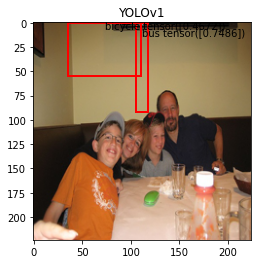

{'img': tensor([[[0.2000, 0.0941, 0.0627],
          [0.2118, 0.1020, 0.0667],
          [0.2118, 0.1176, 0.0784],
          ...,
          [0.3608, 0.2510, 0.1412],
          [0.3529, 0.2510, 0.1451],
          [0.3490, 0.2471, 0.1412]],
 
         [[0.2157, 0.1020, 0.0706],
          [0.2196, 0.1137, 0.0784],
          [0.2275, 0.1255, 0.0902],
          ...,
          [0.3608, 0.2588, 0.1412],
          [0.3608, 0.2588, 0.1529],
          [0.3569, 0.2549, 0.1490]],
 
         [[0.2275, 0.1137, 0.0706],
          [0.2275, 0.1216, 0.0784],
          [0.2275, 0.1176, 0.0784],
          ...,
          [0.3647, 0.2667, 0.1490],
          [0.3608, 0.2588, 0.1490],
          [0.3569, 0.2549, 0.1490]],
 
         ...,
 
         [[0.9725, 0.8157, 0.7490],
          [0.9176, 0.7451, 0.6667],
          [0.9529, 0.7608, 0.6980],
          ...,
          [0.7294, 0.5804, 0.4784],
          [0.6667, 0.4745, 0.3569],
          [0.6353, 0.4353, 0.3020]],
 
         [[0.9882, 0.8510, 0.7882],
     

In [157]:
# 예측해보기
YOLO_model.load_state_dict(torch.load("./yolov1.pt"))
img, label = Test_Dataset[300]

out = detect(YOLO_model, img.unsqueeze(0))

draw(out)